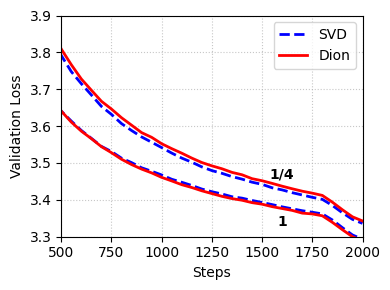

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


# ─── Load CSV data ───────────────────────────────────────────────────────────
def load_results(csv_file):
    df = pd.read_csv(csv_file)

    # Keep only columns with (svd) and (power) and exclude __MIN and __MAX
    cols = [
        col
        for col in df.columns
        if ("(svd)" in col or "(power)" in col)
        and "__MIN" not in col
        and "__MAX" not in col
    ]
    cols.insert(0, "Step")  # Ensure 'Step' is included
    df = df[cols]

    return df


# ─── Extract fraction from Dion label ────────────────────────────────────────
def extract_fraction(opt_name):
    match = re.search(r"dion_(\d+)", opt_name)
    if match:
        fraction = match.group(1)
        return "1" if fraction == "1" else f"1/{fraction}"
    return "1"


# ─── Plotting Function (modified) ────────────────────────────────────────────
def plot_results(df, ylim=None, figsize=(4, 4), save_path="svd_power_comparison.pdf"):
    fig, ax = plt.subplots(figsize=figsize)

    styles = {
        "(svd)": {"linewidth": 2, "linestyle": "--", "color": "blue"},
        "(power)": {"linewidth": 2, "linestyle": "-", "color": "red"},
    }

    fractions = ["1", "1/2", "1/4", "1/8", "1/16"]
    offsets = {"1": 0.05, "1/2": -0.05, "1/4": 0.13, "1/8": 0.05, "1/16": 0.05}

    fraction_coords = {}  # Store coordinates for annotation

    plotted_labels = set()

    for col in df.columns:
        if col == "Step":
            continue

        method = "(svd)" if "(svd)" in col else "(power)"
        label_base = "SVD" if "(svd)" in col else "Dion"
        frac = extract_fraction(col)

        steps = df["Step"]
        losses = df[col]
        valid = ~losses.isna()

        label = label_base if label_base not in plotted_labels else "_nolegend_"
        plotted_labels.add(label_base)

        ax.plot(steps[valid], losses[valid], label=label, **styles[method])

        # Store fraction annotation coordinates (average position)
        if frac in fractions:
            if frac not in fraction_coords:
                fraction_coords[frac] = []
            fraction_coords[frac].append(
                (steps[valid].iloc[-1], losses[valid].iloc[-1])
            )

    # Annotate fractions once in black between the curves
    for frac, coords in fraction_coords.items():
        x = np.mean([coord[0] for coord in coords]) - 400
        y = np.mean([coord[1] for coord in coords]) + offsets[frac]
        ax.text(
            x,
            y,
            frac,
            fontsize=10,
            color="black",
            va="center",
            ha="center",
            fontweight="bold",
        )

    ax.set_xlabel("Steps")
    ax.set_ylabel("Validation Loss")

    if ylim:
        ax.set_ylim(3.3, 3.9)

        ax.set_xlim((500, 2000))
    else:
        ax.set_ylim((3.3, 5))

    ax.legend()
    ax.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()

    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()


# ─── Usage ───────────────────────────────────────────────────────────
file_path = "svd_results.csv"
results_df = load_results(file_path)

plot_results(results_df, ylim=(3.3, 3.9), figsize=(4, 3), save_path="dion/svd.pdf")